In [1]:
import pandas as pd
import geopandas as gdp
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
from shapely import wkt
import contextily as ctx

In [94]:
crs = {'init':'EPSG:4326'} # for setting crs when loading gdp

In [2]:
df = pd.read_csv(r'../../Machine Learning/Data Incubator/Motor_Vehicle_Collisions_-_Crashes.csv')

C:\Users\Lenovo\Anaconda3\envs\cs231n\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
# Convert the CRASH DATE and CRASH TIME columns to datetime type
df.iloc[:, 0:2] = df.iloc[:, 0:2].apply(pd.to_datetime, errors='coerce')

In [50]:
# df.info()

In [51]:
# working with smaller data size to start
df = df[df['CRASH DATE'] >= '2019-01-01'].reset_index(drop=True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254571 entries, 0 to 254570
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     254571 non-null  datetime64[ns]
 1   CRASH TIME                     254571 non-null  datetime64[ns]
 2   BOROUGH                        175010 non-null  object        
 3   ZIP CODE                       174962 non-null  object        
 4   LATITUDE                       254571 non-null  float64       
 5   LONGITUDE                      254571 non-null  float64       
 6   LOCATION                       254571 non-null  object        
 7   ON STREET NAME                 188729 non-null  object        
 8   CROSS STREET NAME              125004 non-null  object        
 9   OFF STREET NAME                65819 non-null   object        
 10  NUMBER OF PERSONS INJURED      254571 non-null  float64       
 11  

In [75]:
df.sort_values(['CRASH DATE'], ascending = False)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry
9209,2020-07-31,2020-08-06 22:00:00,NaN,NaN,40.862680,-73.909050,POINT (-73.90905 40.86268),WEST FORDHAM ROAD,SEDGWICK AVENUE,NaN,...,Unspecified,NaN,NaN,4333823,Station Wagon/Sport Utility Vehicle,Sedan,Sedan,NaN,NaN,POINT (-73.90905 40.86268)
15441,2020-07-31,2020-08-06 06:35:00,BROOKLYN,11218,40.642384,-73.980420,POINT (-73.98042 40.642384),DAHILL ROAD,CHURCH AVENUE,NaN,...,NaN,NaN,NaN,4334341,Sedan,Sedan,NaN,NaN,NaN,POINT (-73.98042 40.64238)
8135,2020-07-31,2020-08-06 10:46:00,QUEENS,11377,40.743470,-73.893950,POINT (-73.89395 40.74347),NaN,NaN,41-58 71 STREET,...,NaN,NaN,NaN,4333815,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.89395 40.74347)
4793,2020-07-31,2020-08-06 07:28:00,NaN,NaN,40.711334,-73.933900,POINT (-73.9339 40.711334),MEADOW STREET,NaN,NaN,...,NaN,NaN,NaN,4334026,Station Wagon/Sport Utility Vehicle,Carry All,NaN,NaN,NaN,POINT (-73.93390 40.71133)
12390,2020-07-31,2020-08-06 12:58:00,BROOKLYN,11235,40.590202,-73.953610,POINT (-73.95361 40.590202),NaN,NaN,1610 AVENUE Y,...,NaN,NaN,NaN,4333716,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.95361 40.59020)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246783,2019-01-01,2020-08-06 20:23:00,BROOKLYN,11218,40.640205,-73.985580,POINT (-73.98558 40.640205),NaN,NaN,1325 39 STREET,...,NaN,NaN,NaN,4061129,Van,Sedan,NaN,NaN,NaN,POINT (-73.98558 40.64021)
253550,2019-01-01,2020-08-06 19:00:00,BROOKLYN,11221,40.689700,-73.922455,POINT (-73.922455 40.6897),NaN,NaN,1354 BROADWAY,...,NaN,NaN,NaN,4060606,Ambulance,Sedan,NaN,NaN,NaN,POINT (-73.92245 40.68970)
250649,2019-01-01,2020-08-06 02:20:00,QUEENS,11377,40.748993,-73.896870,POINT (-73.89687 40.748993),BROADWAY,69 STREET,NaN,...,NaN,NaN,NaN,4060564,Sedan,Sedan,NaN,NaN,NaN,POINT (-73.89687 40.74899)
252334,2019-01-01,2020-08-06 03:55:00,NaN,NaN,40.755820,-73.970764,POINT (-73.970764 40.75582),3 AVENUE,NaN,NaN,...,NaN,NaN,NaN,4060430,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (-73.97076 40.75582)


In [76]:
# Getting rid of accidents with NaN locatation
df = df.dropna(subset=['LOCATION']).reset_index(drop=True)

In [78]:
df[(df['LATITUDE']==0)|(df['LONGITUDE']==0)].head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry
166,2019-01-30,2020-08-06 13:34:00,MANHATTAN,10007,0.0,0.0,POINT (0 0),NaN,NaN,101 BARCLAY STREET,...,NaN,NaN,NaN,4072246,Sedan,NaN,NaN,NaN,NaN,POINT (0.00000 0.00000)
176,2019-01-29,2020-08-06 11:07:00,NaN,NaN,0.0,0.0,POINT (0 0),KINGS HIGHWAY,EAST 32 STREET,NaN,...,NaN,NaN,NaN,4072149,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (0.00000 0.00000)
180,2019-01-29,2020-08-06 18:47:00,NaN,NaN,0.0,0.0,POINT (0 0),WEST 230 STREET,BROADWAY,NaN,...,NaN,NaN,NaN,4072064,Taxi,NaN,NaN,NaN,NaN,POINT (0.00000 0.00000)
187,2020-06-16,2020-08-06 02:59:00,QUEENS,11370,0.0,0.0,POINT (0 0),NaN,NaN,25-46 82 STREET,...,NaN,NaN,NaN,4321046,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (0.00000 0.00000)
188,2019-10-09,2020-08-06 05:10:00,BROOKLYN,11207,0.0,0.0,POINT (0 0),NaN,NaN,561 WYONA STREET,...,NaN,NaN,NaN,4220275,NaN,NaN,NaN,NaN,NaN,POINT (0.00000 0.00000)


In [79]:
# Get rid of locations that are zero for now
df = df[(df['LATITUDE']!=0)|(df['LONGITUDE']!=0)].reset_index(drop=True)

In [80]:
df

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry
0,2019-08-05,2020-08-06 01:50:00,BROOKLYN,11207,40.687984,-73.907430,POINT (-73.90743 40.687984),NaN,NaN,662 CENTRAL AVENUE,...,NaN,NaN,NaN,4183103,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.90743 40.68798)
1,2019-11-01,2020-08-06 18:30:00,NaN,NaN,40.835117,-73.873910,POINT (-73.87391 40.835117),BRONX RIVER PARKWAY,NaN,NaN,...,NaN,NaN,NaN,4235723,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,POINT (-73.87391 40.83512)
2,2020-07-31,2020-08-06 18:00:00,NaN,NaN,40.746650,-73.969124,POINT (-73.969124 40.74665),FDR DRIVE,NaN,NaN,...,NaN,NaN,NaN,4333751,Sedan,NaN,NaN,NaN,NaN,POINT (-73.96912 40.74665)
3,2019-02-18,2020-08-06 19:00:00,NaN,NaN,40.654488,-73.979034,POINT (-73.979034 40.654488),19 STREET,11 AVENUE,NaN,...,NaN,NaN,NaN,4082969,Sedan,NaN,NaN,NaN,NaN,POINT (-73.97903 40.65449)
4,2019-08-05,2020-08-06 20:00:00,NaN,NaN,40.689510,-73.948044,POINT (-73.948044 40.68951),MARCY AVENUE,NaN,NaN,...,NaN,NaN,NaN,4183749,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (-73.94804 40.68951)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254210,2019-01-13,2020-08-06 20:40:00,STATEN ISLAND,10304,40.591020,-74.100914,POINT (-74.100914 40.59102),RICHMOND ROAD,FOUR CORNERS ROAD,NaN,...,NaN,NaN,NaN,4066151,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-74.10091 40.59102)
254211,2019-01-07,2020-08-06 07:43:00,BRONX,10457,40.847027,-73.898070,POINT (-73.89807 40.847027),WASHINGTON AVENUE,EAST TREMONT AVENUE,NaN,...,NaN,NaN,NaN,4063469,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,POINT (-73.89807 40.84703)
254212,2019-01-19,2020-08-06 11:25:00,NaN,NaN,40.684116,-73.832730,POINT (-73.83273 40.684116),109 STREET,LIBERTY AVENUE,NaN,...,NaN,NaN,NaN,4057680,Pick-up Truck,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.83273 40.68412)
254213,2019-01-08,2020-08-06 23:45:00,BROOKLYN,11234,40.608204,-73.920715,POINT (-73.920715 40.608204),AVENUE V,FLATBUSH AVENUE,NaN,...,NaN,NaN,NaN,4064254,Sedan,NaN,NaN,NaN,NaN,POINT (-73.92072 40.60820)


In [95]:
# Use CRS do define it at start
gdf = gdp.GeoDataFrame(
    df, geometry=gdp.points_from_xy(df.LONGITUDE, df.LATITUDE), crs=crs)

C:\Users\Lenovo\Anaconda3\envs\cs231n\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [96]:
gdf.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry
0,2019-08-05,2020-08-06 01:50:00,BROOKLYN,11207,40.687984,-73.907430,POINT (-73.90743 40.687984),NaN,NaN,662 CENTRAL AVENUE,...,NaN,NaN,NaN,4183103,Taxi,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.90743 40.68798)
1,2019-11-01,2020-08-06 18:30:00,NaN,NaN,40.835117,-73.873910,POINT (-73.87391 40.835117),BRONX RIVER PARKWAY,NaN,NaN,...,NaN,NaN,NaN,4235723,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,POINT (-73.87391 40.83512)
2,2020-07-31,2020-08-06 18:00:00,NaN,NaN,40.746650,-73.969124,POINT (-73.969124 40.74665),FDR DRIVE,NaN,NaN,...,NaN,NaN,NaN,4333751,Sedan,NaN,NaN,NaN,NaN,POINT (-73.96912 40.74665)
3,2019-02-18,2020-08-06 19:00:00,NaN,NaN,40.654488,-73.979034,POINT (-73.979034 40.654488),19 STREET,11 AVENUE,NaN,...,NaN,NaN,NaN,4082969,Sedan,NaN,NaN,NaN,NaN,POINT (-73.97903 40.65449)
4,2019-08-05,2020-08-06 20:00:00,NaN,NaN,40.689510,-73.948044,POINT (-73.948044 40.68951),MARCY AVENUE,NaN,NaN,...,NaN,NaN,NaN,4183749,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (-73.94804 40.68951)


In [97]:
gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [103]:
# Now convert it
gdf = gdf.to_crs("EPSG:3857")

In [104]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

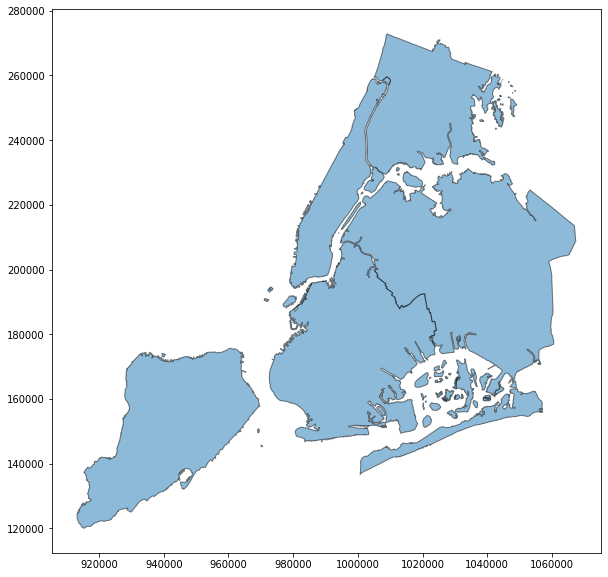

In [105]:
nyc = gdp.read_file(gdp.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k',)

In [106]:
nyc.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [107]:
# Convert to WGS 84 coordinate system
nyc = nyc.to_crs("EPSG:3857")

In [108]:
nyc.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

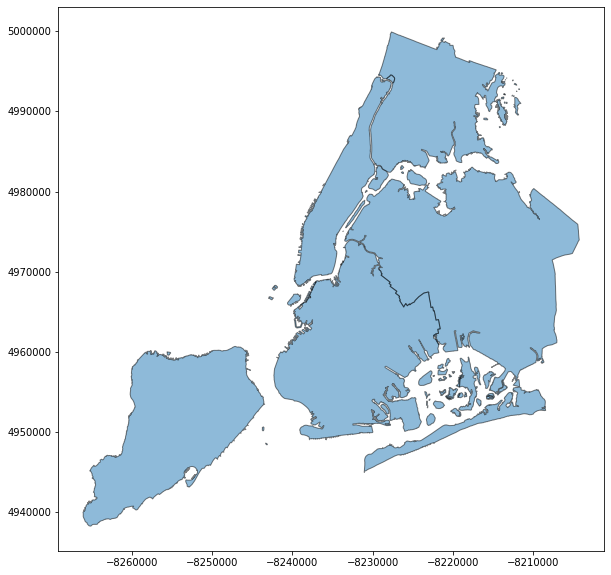

In [109]:
ax =nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

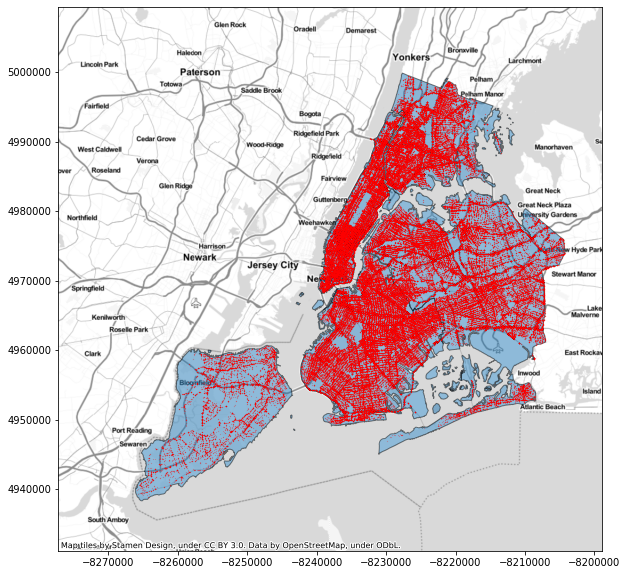

In [110]:
# df1 = gdp.read_file(gdp.datasets.get_path('nybb'))
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_LITE)
gdf.plot(ax=ax, color='red', markersize=.01)
plt.show()

In [ ]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

In [28]:
# To start with, Looking only on leathal accidents with fatalaties

In [40]:
df = df[(df['NUMBER OF PERSONS KILLED'] > 1)].reset_index(drop=True)

In [43]:
df.dropna(axis=1, how='all')

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry
0,05/01/2018,14:51,NaN,NaN,40.601734,-73.935036,POINT (-73.935036 40.601734),AVENUE U,GERRITSEN AVENUE,NaN,...,Unspecified,Unspecified,Unspecified,3892146,Station Wagon/Sport Utility Vehicle,Sedan,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,POINT (-73.93504 40.60173)
1,12/27/2016,5:41,NaN,NaN,40.844604,-73.903480,POINT (-73.90348 40.844604),CROSS BRONX EXPY,NaN,NaN,...,Unspecified,Unspecified,NaN,3588439,Tractor Truck Diesel,Sedan,Tractor Truck Diesel,Pick-up Truck,NaN,POINT (-73.90348 40.84460)
2,06/21/2020,21:23,NaN,NaN,NaN,NaN,NaN,CITY ISLAND ROAD,NaN,NaN,...,Unspecified,Unspecified,Unspecified,4322266,Sedan,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,POINT (nan nan)
3,06/11/2020,1:34,NaN,NaN,NaN,NaN,NaN,BRONX RIVER PARKWAY RAMP,NaN,NaN,...,NaN,NaN,NaN,4319230,Sedan,NaN,NaN,NaN,NaN,POINT (nan nan)
4,07/11/2020,20:18,BROOKLYN,11234,40.589930,-73.900590,POINT (-73.90059 40.58993),NaN,NaN,3159 FLATBUSH AVENUE,...,NaN,NaN,NaN,4327676,Sedan,Sedan,NaN,NaN,NaN,POINT (-73.90059 40.58993)
5,07/20/2020,23:46,NaN,NaN,40.835087,-73.825380,POINT (-73.82538 40.835087),BRUCKNER EXPRESSWAY,NaN,NaN,...,Unspecified,Unspecified,Unspecified,4330670,Sedan,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,POINT (-73.82538 40.83509)
6,04/26/2020,3:35,NaN,NaN,40.811428,-73.900910,POINT (-73.90091 40.811428),BRUCKNER BOULEVARD,NaN,NaN,...,NaN,NaN,NaN,4310365,Sedan,NaN,NaN,NaN,NaN,POINT (-73.90091 40.81143)
7,01/25/2020,5:35,NaN,NaN,40.748398,-73.728790,POINT (-73.72879 40.748398),GRAND CENTRAL PKWY,NaN,NaN,...,NaN,NaN,NaN,4278634,Sedan,Sedan,NaN,NaN,NaN,POINT (-73.72879 40.74840)
8,10/04/2019,18:45,NaN,NaN,40.825283,-73.886480,POINT (-73.88648 40.825283),WHITLOCK AVENUE,NaN,NaN,...,NaN,NaN,NaN,4218016,Sedan,NaN,NaN,NaN,NaN,POINT (-73.88648 40.82528)
9,08/11/2019,3:45,NaN,NaN,40.798060,-73.975540,POINT (-73.97554 40.79806),HENRY HUDSON PARKWAY,NaN,NaN,...,NaN,NaN,NaN,4187133,Sedan,NaN,NaN,NaN,NaN,POINT (-73.97554 40.79806)


In [7]:
%matplotlib inline

In [9]:
streat_map = gdp.read_file('NYC_shapefile/CHS_2009_DOHMH_2010B.shp')

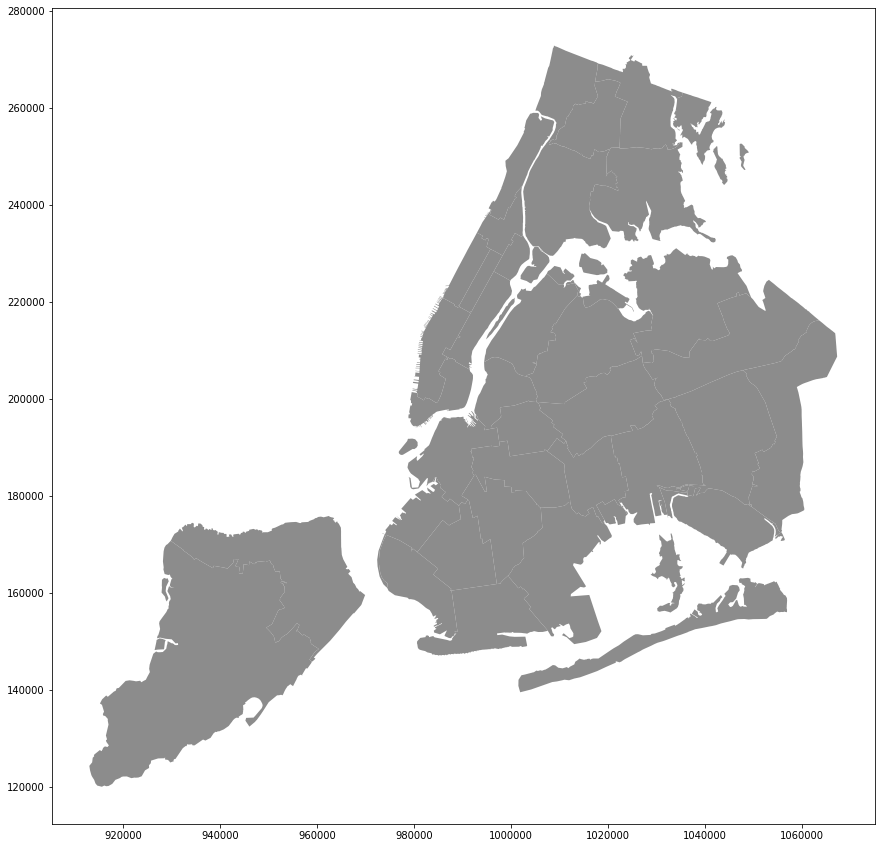

In [16]:
fig, ax = plt.subplots(figsize = (15,15))
streat_map.plot(ax = ax, alpha = .9, color = 'grey')

In [18]:
# Place on map locations of accidents

In [32]:
geo = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

In [35]:
geo_df = gdp.GeoDataFrame(df, geometry = geo)

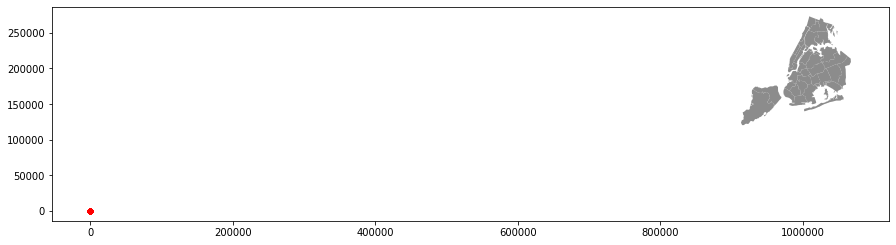

In [36]:
fig, ax = plt.subplots(figsize = (15,15))
streat_map.plot(ax = ax, alpha = .9, color = 'grey')
geo_df.plot(ax = ax, markersize = 20, color = 'red', marker = 'o')

In [13]:
# Using Nominatim api to find coordinates if street is avilable but coordinates are not

Query examples:

https://nominatim.openstreetmap.org/search?q=564+1st+ave+new+york+ny+10016&format=json

https://nominatim.openstreetmap.org/ui/search.html?street=564+1st+ave&city=nyc
